<a href="https://colab.research.google.com/github/priyeshkapadia/dl_pytorch/blob/main/PyTorch_Bike_Sharing_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install livelossplot --quiet

In [62]:
import numpy as np
import pandas as pd
import plotly.express as px
import torch
import torch.utils.data as data_utils

from livelossplot import PlotLosses
from livelossplot.outputs import BokehPlot

In [24]:
pd.options.display.max_rows = 100

In [53]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


## Connect to Google Drive

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive/Udacity/deep-learning-v2-pytorch/project-bikesharing'

/content/drive/My Drive/Udacity/deep-learning-v2-pytorch/project-bikesharing


## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [ ]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

data = pd.read_csv(data_path)

https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset

- instant: record index
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
 1. Clear, Few clouds, Partly cloudy, Partly cloudy
 2. Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
 3. Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
 4. Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In [ ]:
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [ ]:
data['datetime'] = pd.to_datetime(data['dteday'] + ' ' + data['hr'].astype(str) + ':00:00')

## EDA

In [ ]:
fig = px.line(data, x='datetime', y="cnt")
fig.show()

In [ ]:
data.groupby(['yr', 'season'])['cnt'].sum().reset_index()

,yr,season,cnt
0,0,1,150000
1,0,2,347316
2,0,3,419650
3,0,4,326137
4,1,1,321348
5,1,2,571273
6,1,3,641479
7,1,4,515476


In [ ]:
plot_df = data.groupby(['yr', 'season'])['cnt'].mean().reset_index()
plot_df['season'] = plot_df['season'].astype(str)

fig = px.bar(
    plot_df,
    x="yr",
    y="cnt",
    color="season",
    barmode="group",
    title="Number of Bikes Rented per Season"
)
fig.show()

In [ ]:
fig = px.violin(
    data,
    x='season',
    y='cnt',
    color='season',
    title='Number of Bikes Rented per Season'
)
fig.show()

In [ ]:
plot_df = data.groupby(['hr'])['cnt'].mean().reset_index()

fig = px.bar(
    plot_df,
    x="hr",
    y="cnt",
    barmode="group",
    title="Number of Bikes Rented per Hour"
)
fig.show()

In [ ]:
fig = px.violin(
    data,
    x='mnth',
    y='cnt',
    title='Number of Bikes Rented per Season'
)
fig.show()

In [ ]:
plot_df = data.groupby(['mnth', 'workingday'])['cnt'].mean().reset_index()
plot_df['workingday'] = plot_df['workingday'].astype(str)

fig = px.bar(
    plot_df,
    x="mnth",
    y="cnt",
    color="workingday",
    barmode="group",
    title="Number of Bikes Rented per Hour"
)
fig.show()

In [ ]:
fig = px.scatter(data, x='temp', y='cnt')
fig.show()

In [27]:
feature_cols = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']

In [42]:
features_df = data[feature_cols]
target_df = data[['cnt']]

In [43]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
features_df = pd.get_dummies(features_df, columns=dummy_fields)

In [44]:
features_df.head().T

,0,1,2,3,4
yr,0.0000,0.0000,0.0000,0.0000,0.0000
holiday,0.0000,0.0000,0.0000,0.0000,0.0000
workingday,0.0000,0.0000,0.0000,0.0000,0.0000
temp,0.2400,0.2200,0.2200,0.2400,0.2400
atemp,0.2879,0.2727,0.2727,0.2879,0.2879
hum,0.8100,0.8000,0.8000,0.7500,0.7500
windspeed,0.0000,0.0000,0.0000,0.0000,0.0000
season_1,1.0000,1.0000,1.0000,1.0000,1.0000
season_2,0.0000,0.0000,0.0000,0.0000,0.0000
season_3,0.0000,0.0000,0.0000,0.0000,0.0000


In [45]:
X_train_df = features_df[:-21*24]
y_train_df = target_df[:-21*24]

X_test_df = features_df[-21*24:]
y_test_df = target_df[-21*24:]

In [46]:
X_train_tensor = torch.tensor(X_train_df.values, dtype=torch.float)
X_test_tensor = torch.tensor(X_test_df.values, dtype=torch.float)
y_train_tensor = torch.tensor(y_train_df.values, dtype=torch.float)
y_test_tensor = torch.tensor(y_test_df.values, dtype=torch.float)

In [47]:
print('X_train_tensor.shape =', X_train_tensor.shape)
print('X_test_tensor.shape =', X_test_tensor.shape)
print('y_train_tensor.shape =', y_train_tensor.shape)
print('y_test_tensor.shape =', y_test_tensor.shape)

X_train_tensor.shape = torch.Size([16875, 58])
X_test_tensor.shape = torch.Size([504, 58])
y_train_tensor.shape = torch.Size([16875, 1])
y_test_tensor.shape = torch.Size([504, 1])


In [48]:
train_data = data_utils.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = data_utils.DataLoader(train_data, batch_size=1000, shuffle=True)
len(train_loader)

17

In [49]:
features_batch, target_batch = next(iter(train_loader))
print('features_batch.shape =',features_batch.shape)
print('target_batch.shape =',target_batch.shape)

features_batch.shape = torch.Size([1000, 58])
target_batch.shape = torch.Size([1000, 1])


In [50]:
inp = X_train_tensor.shape[1]
out = 1
hid = 5
loss_fn = torch.nn.MSELoss()

In [58]:
model = torch.nn.Sequential(
    torch.nn.Linear(inp, hid),
    torch.nn.ReLU(),
    torch.nn.Linear(hid, out)
)
model

Sequential(
  (0): Linear(in_features=58, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [59]:
if train_on_gpu:
    model = model.cuda()

In [60]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

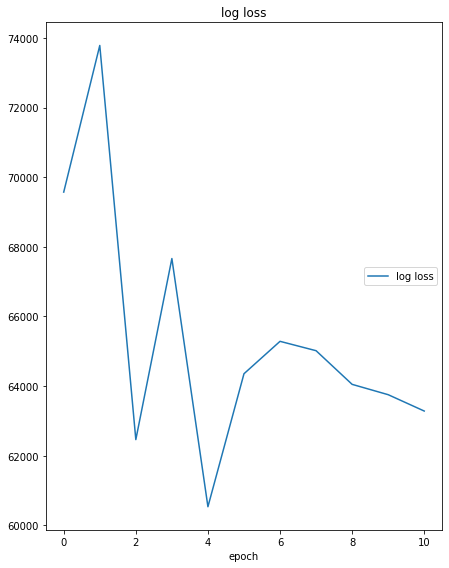

log loss
	log loss         	 (min: 60536.008, max: 73782.883, cur: 63284.305)


In [66]:
total_step = len(train_loader)
num_epochs = 10
liveloss = PlotLosses()
for epoch in range(num_epochs + 1):
    logs = {}
    for i, (features, target) in enumerate(train_loader):
        output = model(features)
        loss = loss_fn(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    logs['log loss'] = loss.item()
    if epoch % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss {loss.item():.4f}')
    
    liveloss.update(logs)
    liveloss.send()